# Customer churn prediction

### 1. Data Loading & Libraries
    
Load customer churn data and import the necessary libraries for EDA, preprocessing, and modeling.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, cohen_kappa_score
from xgboost import XGBClassifier

In [4]:
train = pd.read_csv("/Users/strou/OneDrive - LUT University/GitHub/train.csv")
test = pd.read_csv("/Users/strou/OneDrive - LUT University/GitHub/test.csv")

### 2. Exploratory Data Analysis (EDA)
   
   These plots show churn rates by state, area_code, international_plan, and voice_mail_plan

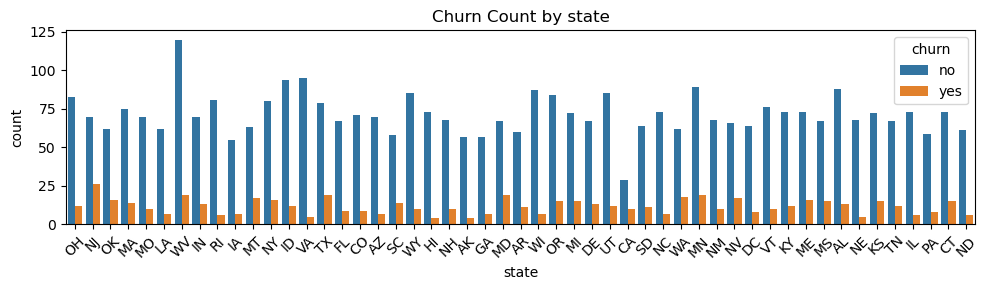

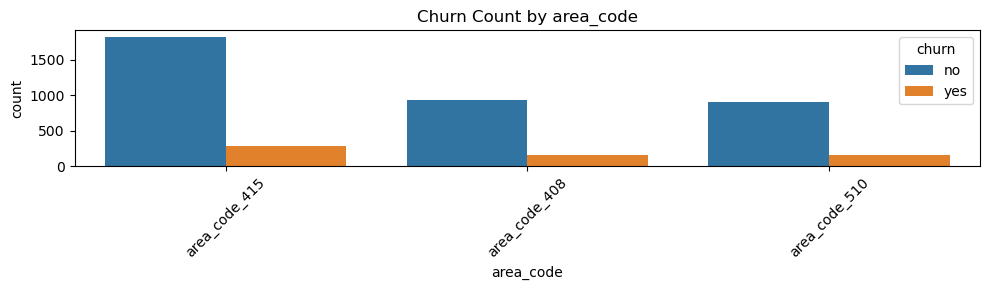

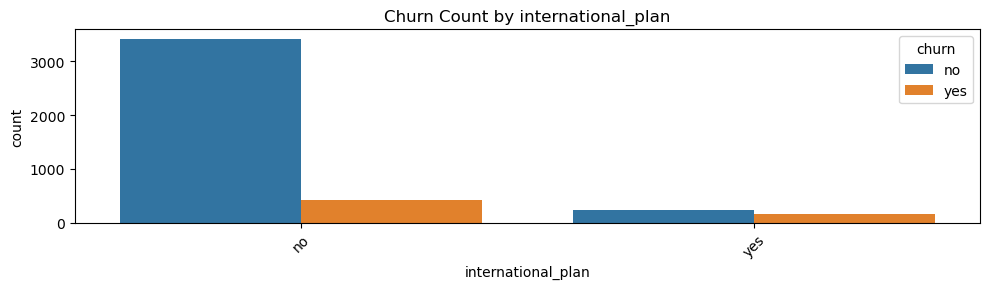

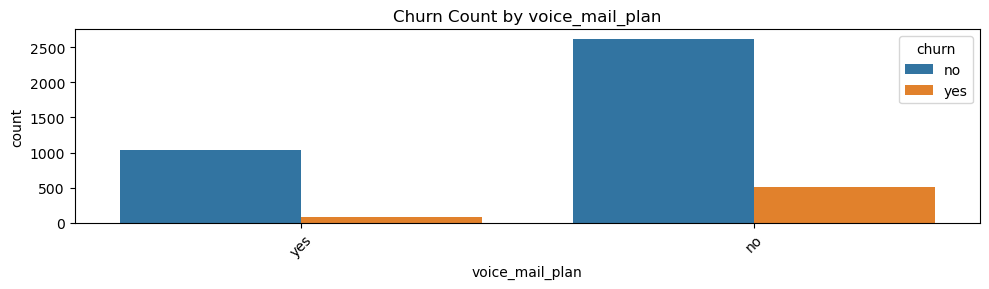

In [6]:

categorical_vars = ['state', 'area_code', 'international_plan', 'voice_mail_plan']

for var in categorical_vars:
    plt.figure(figsize=(10, 3))
    sns.countplot(x=var, hue='churn', data=train)
    plt.title(f'Churn Count by {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 3. Preprocessing

   Handling Categorical Data.
   Converts the target to binary.
   Capping extreme values avoids skewed models.

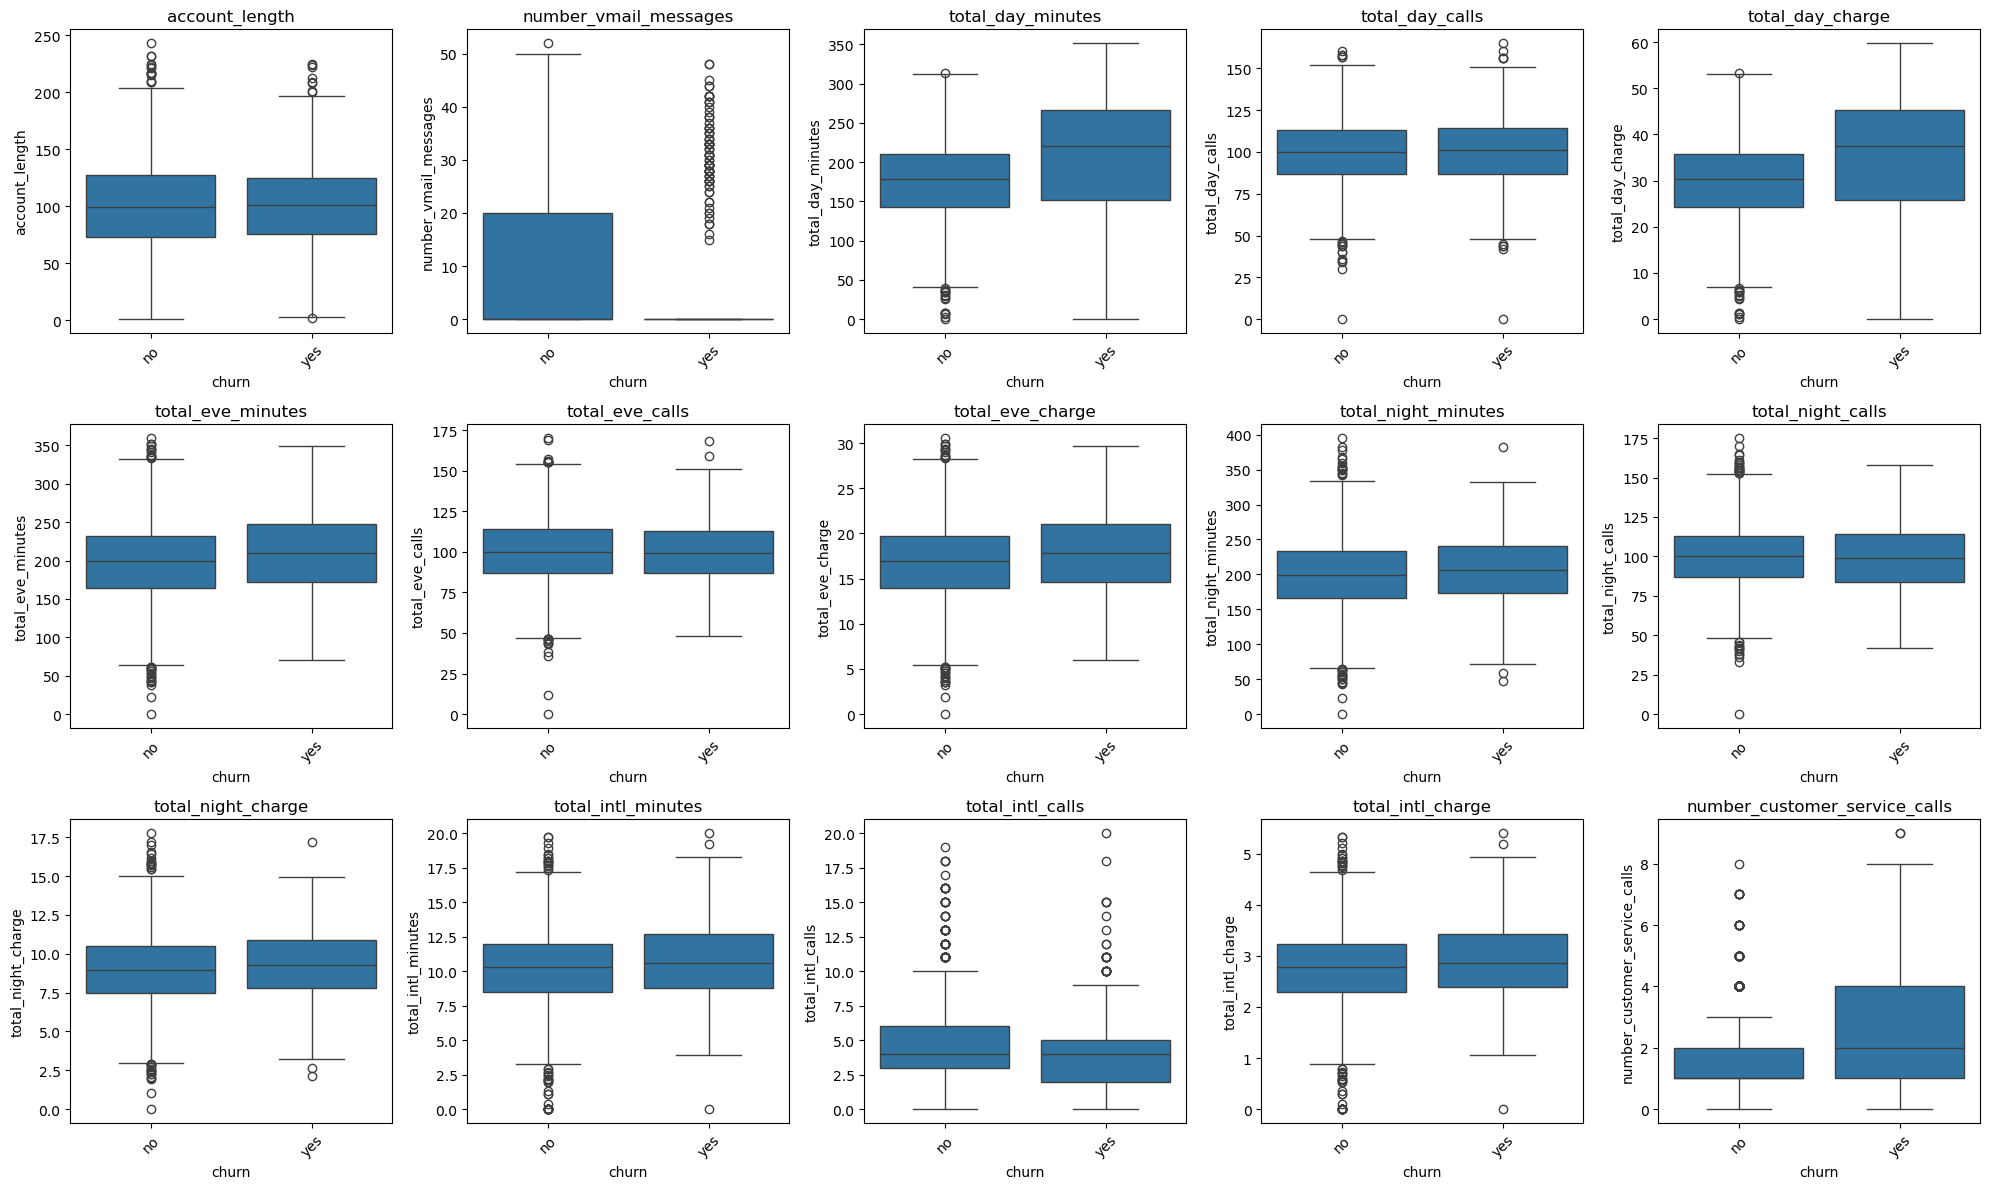

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical variables
numerical_vars = ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 
    'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
    'total_night_minutes', 'total_night_calls', 'total_night_charge',
    'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
    'number_customer_service_calls']

fig, axes = plt.subplots(3, 5, figsize=(20, 12)) 

axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='churn', y=var, data=train, ax=axes[i])
    axes[i].set_title(var)
    axes[i].tick_params(axis='x', labelrotation=45)

for j in range(len(numerical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
train['churn'] = train['churn'].map({'yes': 1, 'no': 0}) 
# Only numerical columns
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('churn')  # Exclude target

outlier_limits = {}
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outlier_limits['lower_limit_' + col] = lower_limit
    outlier_limits['upper_limit_' + col] = upper_limit


In this step, we identify and calculate the lower and upper bounds for outliers using the Interquartile Range (IQR) method for each numerical column in the dataset (excluding the target variable churn).

Outliers are extreme values that can skew the distribution of data and negatively impact the performance of machine learning models

In [11]:
for col in num_cols:
    train[col] = np.where(
        train[col] > outlier_limits['upper_limit_' + col],
        outlier_limits['upper_limit_' + col],
        np.where(
            train[col] < outlier_limits['lower_limit_' + col],
            outlier_limits['lower_limit_' + col],
            train[col]
        )
    )

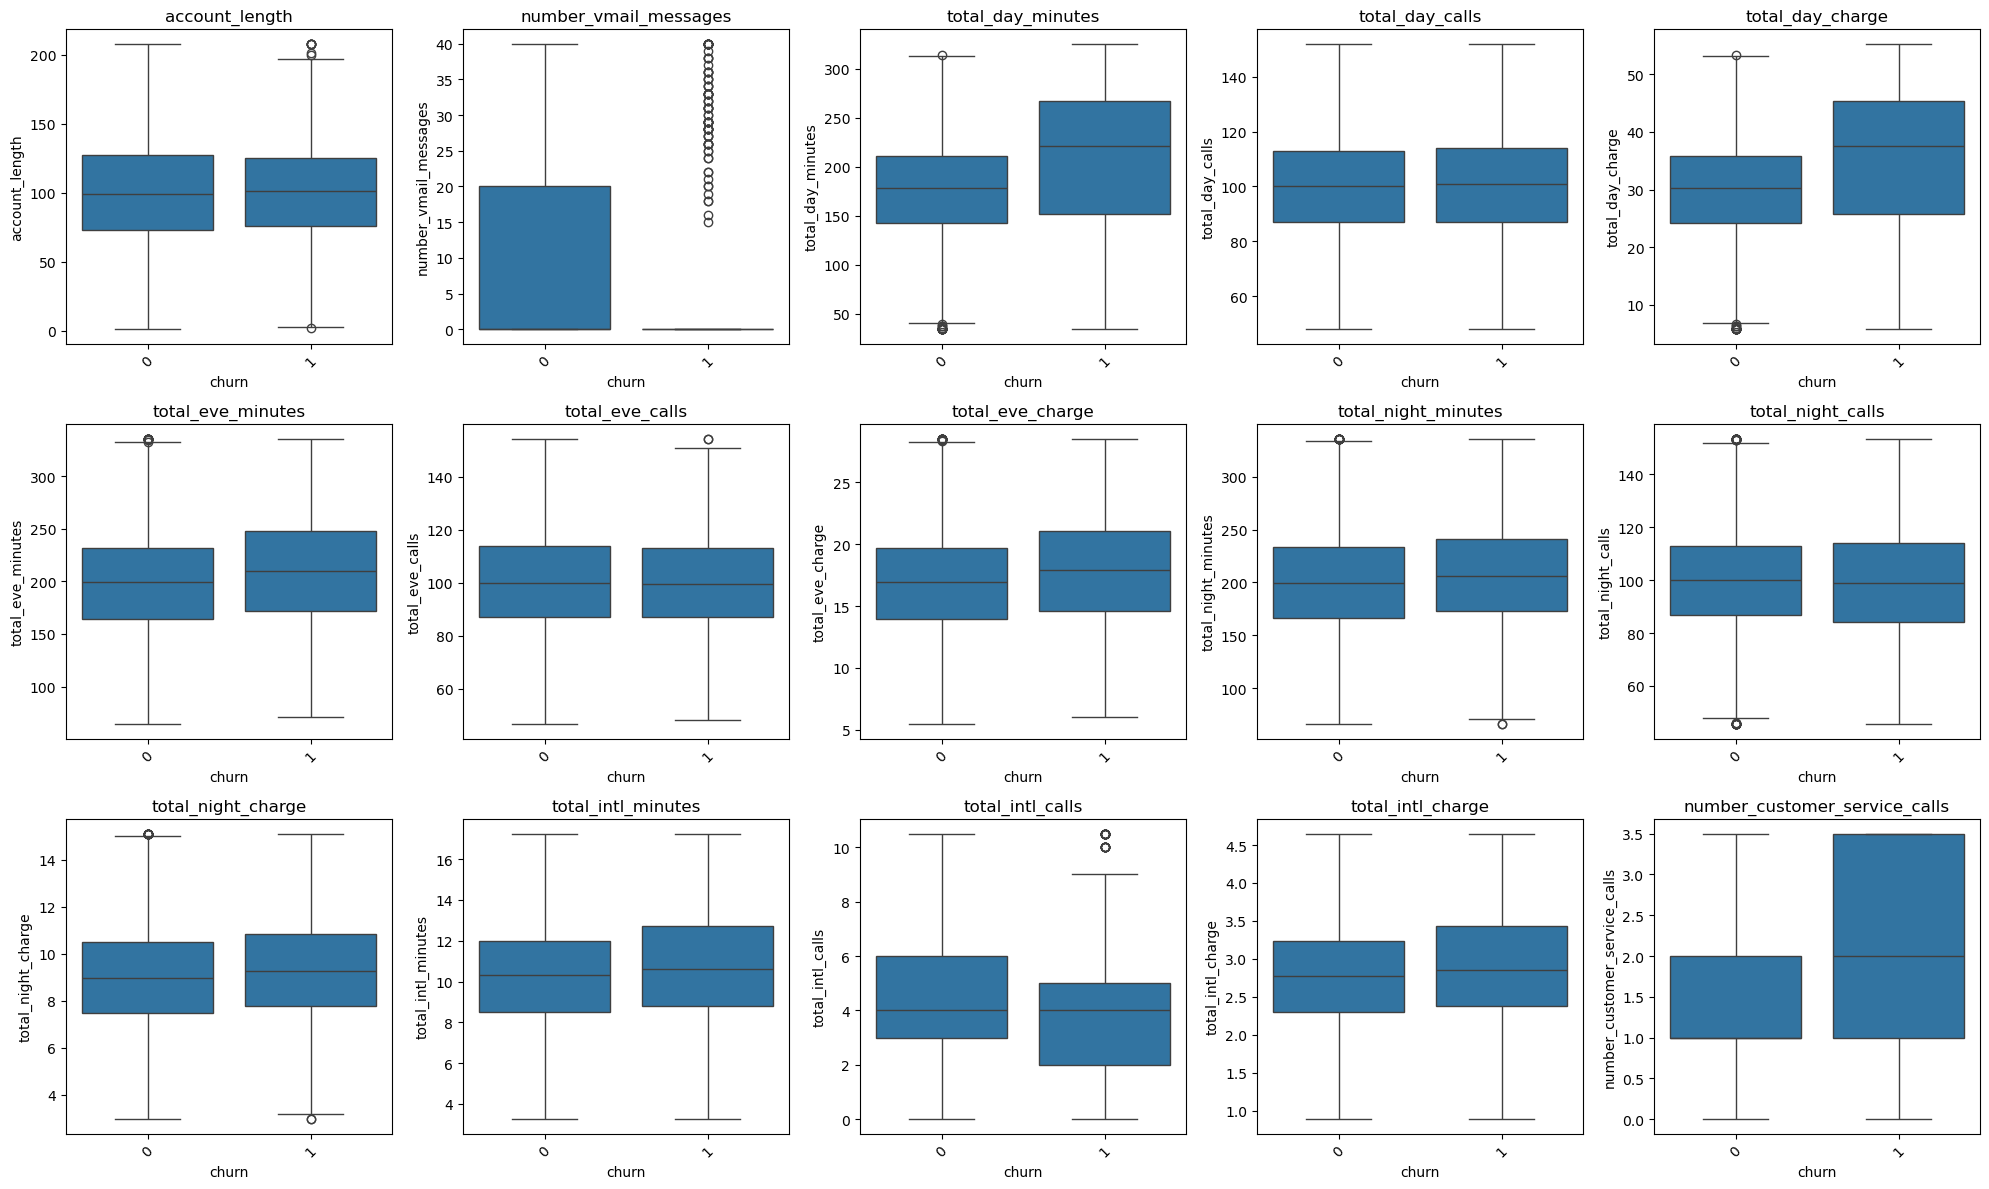

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12)) 

axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='churn', y=var, data=train, ax=axes[i])
    axes[i].set_title(var)
    axes[i].tick_params(axis='x', labelrotation=45)

for j in range(len(numerical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
# Describe the string data
train.describe(include='O')

,state,area_code,international_plan,voice_mail_plan
count,4250,4250,4250,4250
unique,51,3,2,2
top,WV,area_code_415,no,no
freq,139,2108,3854,3138


In this step, we convert the international_plan and voice_mail_plan columns into binary numerical values using simple mapping:

In [15]:
train['international_plan'] = train['international_plan'].map({'yes': 1, 'no': 0}) 
train['voice_mail_plan'] = train['voice_mail_plan'].map({'yes': 1, 'no': 0}) 

test['international_plan'] = test['international_plan'].map({'yes': 1, 'no': 0})
test['voice_mail_plan'] = test['voice_mail_plan'].map({'yes': 1, 'no': 0}) 

id_submission = test.id
test = test.drop('id', axis=1)

These two features are binary categorical variables, meaning they have only two unique values: 'yes' and 'no'. For such features, label encoding (0/1) is both efficient and meaningful — no need for one-hot encoding, since there's no ambiguity or ordinal issue.

In contrast, features like state and area_code have more than two categories, and their values do not have a natural order. For these, we use one-hot encoding to create separate binary columns for each category, avoiding the risk of introducing false ordinal relationships.

This mixed encoding strategy keeps the data clean and compact while ensuring that models can interpret the features correctly.

One-hot encode for the variables "state" and "area code"

In [18]:
onehot_area = OneHotEncoder()
categorical_features = ['state', 'area_code']

for i in categorical_features:
    onehot_area.fit(train[[i]])
    # Train
    encoded_values = onehot_area.transform(train[[i]])
    train[onehot_area.categories_[0]] = encoded_values.toarray()
    train = train.drop(i, axis=1)

    # Test
    encoded_values = onehot_area.transform(test[[i]])
    test[onehot_area.categories_[0]] = encoded_values.toarray()
    test = test.drop(i, axis=1)


In [19]:
# Prepare data for model
df = train.copy()
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 4. Feature Scaling

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

### 5. Model Training

#### XGBoost Classifier

In [24]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.7, 
                        subsample=0.8, nthread=10, learning_rate=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.9576470588235294
Classification report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1102
           1       0.98      0.70      0.82       173

    accuracy                           0.96      1275
   macro avg       0.97      0.85      0.90      1275
weighted avg       0.96      0.96      0.95      1275

Confusion Matrix
[[1100    2]
 [  52  121]]
Cohen kappa score: 
0.7943806332538929


Interpretation:

The model performs very well overall, with high precision in identifying churners — meaning most predicted churns are correct.
<br>
However, the recall is moderate, indicating that around 30% of actual churners are missed.
<br>
Cohen's kappa score (~0.79) suggests strong agreement beyond chance.

#### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.96
Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1102
           1       1.00      0.71      0.83       173

    accuracy                           0.96      1275
   macro avg       0.98      0.85      0.90      1275
weighted avg       0.96      0.96      0.96      1275

Confusion Matrix
[[1102    0]
 [  51  122]]
Cohen kappa score: 
0.805263646518704


Interpretation:

This model is also very strong but slightly underperforms compared to XGBoost in terms of both recall and Cohen’s kappa.
<br>
It misses slightly more churners (lower recall), though it maintains high precision.

### Conclusion:
Both models perform well, but XGBoost offers a better balance between precision and recall, making it the preferred choice in this case.

If the business goal is to catch as many churners as possible, improving recall (e.g., by adjusting decision thresholds or using cost-sensitive learning) could be a valuable next step.